# Independence Tests Power over Increasing Dimension

These are same useful functions to import. Since we are calculating the statistical power over all the tests for all the simulations, we can just use a wild card import from the respective modules

In [1]:
import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt

from benchmarks import power_dim
from hyppo.independence import *
from hyppo.sims import *

sys.path.append(os.path.realpath('..'))

In [2]:
import seaborn as sns
sns.color_palette('Set1')
sns.set(color_codes=True, style='white', context='talk', font_scale=2)
sns.set_palette(sns.color_palette(['c', 'm', 'y', 'k']))

These are some constants that are used in this notebook. If running these notebook, please only manipulate these constants if you are not running more tests. They define the number of replications. The simulations tested over and the independence tests tested over are defined also.

In [3]:
POWER_REPS = 5

In [4]:
simulations = [
    linear,
    exponential,
    cubic,
    joint_normal,
    step,
    quadratic,
    w_shaped,
    spiral,
    uncorrelated_bernoulli,
    logarithmic,
    fourth_root,
    sin_four_pi,
    sin_sixteen_pi,
    square,
    two_parabolas,
    circle,
    ellipse,
    diamond,
    multiplicative_noise,
    multimodal_independence
]

tests = [
    MGC,
    CCA,
    Dcorr,
    HHG,
    Hsic,
    RV,
]

These helper functions return the number of dimensions to test over and the range for each simulation. Limits were chosen based on when it is clear to determine that the tests were tending to 0 statistical power.

In [5]:
def find_dim(sim):
    if sim not in simulations:
        raise ValueError("Invalid simulation")
        
    if sim in [joint_normal, sin_four_pi, sin_sixteen_pi, multiplicative_noise]:
        dim = 10
    elif sim in [multimodal_independence, uncorrelated_bernoulli, logarithmic]:
        dim = 100
    elif sim in [linear, exponential, cubic]:
        dim = 1000
    elif sim in [square, diamond]:
        dim = 40
    else:
        dim = 20
        
    return dim

def find_dim_range(dim):
    if dim < 20:
        lim = 10
    else:
        lim = 20
    
    dim_range = list(range(int(dim/lim), dim+1, int(dim/lim)))
    if int(dim/lim) != 1:
        dim_range.insert(0, 1)
    return dim_range

The following function calculates the estimated power ``POWER_REPS`` number off times and averages them. It does this iterating over the number of sample sizes.

**Note: We only recommend running this code if running the next 2 cells ONCE to generate the csv files used to visualize the plots. This code takes a very long time to run and if running, we recommend using a machine with many cores.**

In [6]:
def estimate_power(sim, test):
    dim = find_dim(sim)
    dim_range = find_dim_range(dim)
    est_power = np.array([np.mean([power_dim(test, sim, p=dim) for _ in range(POWER_REPS)])
                          for dim in dim_range])
    np.savetxt('../benchmarks/vs_dimension/{}_{}.csv'.format(sim.__name__, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [7]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in simulations for test in tests]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

The following code loops over each saved independence test file and generates absolute power curves for each test and for each simulation modality.

In [8]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(28,24))
    
    sim_title = [
        "Linear",
        "Exponential",
        "Cubic",
        "Joint Normal",
        "Step",
        "Quadratic",
        "W-Shaped",
        "Spiral",
        "Bernoulli",
        "Logarithmic",
        "Fourth Root",
        "Sine 4\u03C0",
        "Sine 16\u03C0",
        "Square",
        "Two Parabolas",
        "Circle",
        "Ellipse",
        "Diamond",
        "Multiplicative",
        "Independence"
    ]
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = simulations[count]
            
            for test in tests:
                power = np.genfromtxt('../benchmarks/vs_dimension/{}_{}.csv'.format(sim.__name__, test.__name__),
                                      delimiter=',')
                dim_range = find_dim_range(find_dim(sim))
                
                custom_color = {
                    "Dcorr" : "b",
                    "Hsic" : "g"
                }
                if test.__name__ in custom_color.keys():
                    if test.__name__ not in ["MGC", "MGCRF"]:
                        col.plot(dim_range, power, custom_color[test.__name__], label=test.__name__, lw=5)
                    else:
                        col.plot(dim_range, power, custom_color[test.__name__], label=test.__name__, lw=2)
                else:
                    col.plot(dim_range, power, label=test.__name__, lw=1)
                col.set_xticks([dim_range[0], dim_range[-1]])
                col.set_ylim(0, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([0, 1])
                col.set_title(sim_title[count])
    
    fig.text(0.5, 0.08, 'Dimensions', ha='center')
    fig.text(0.08, 0.5, 'Absolute Statistical Power', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.08), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)

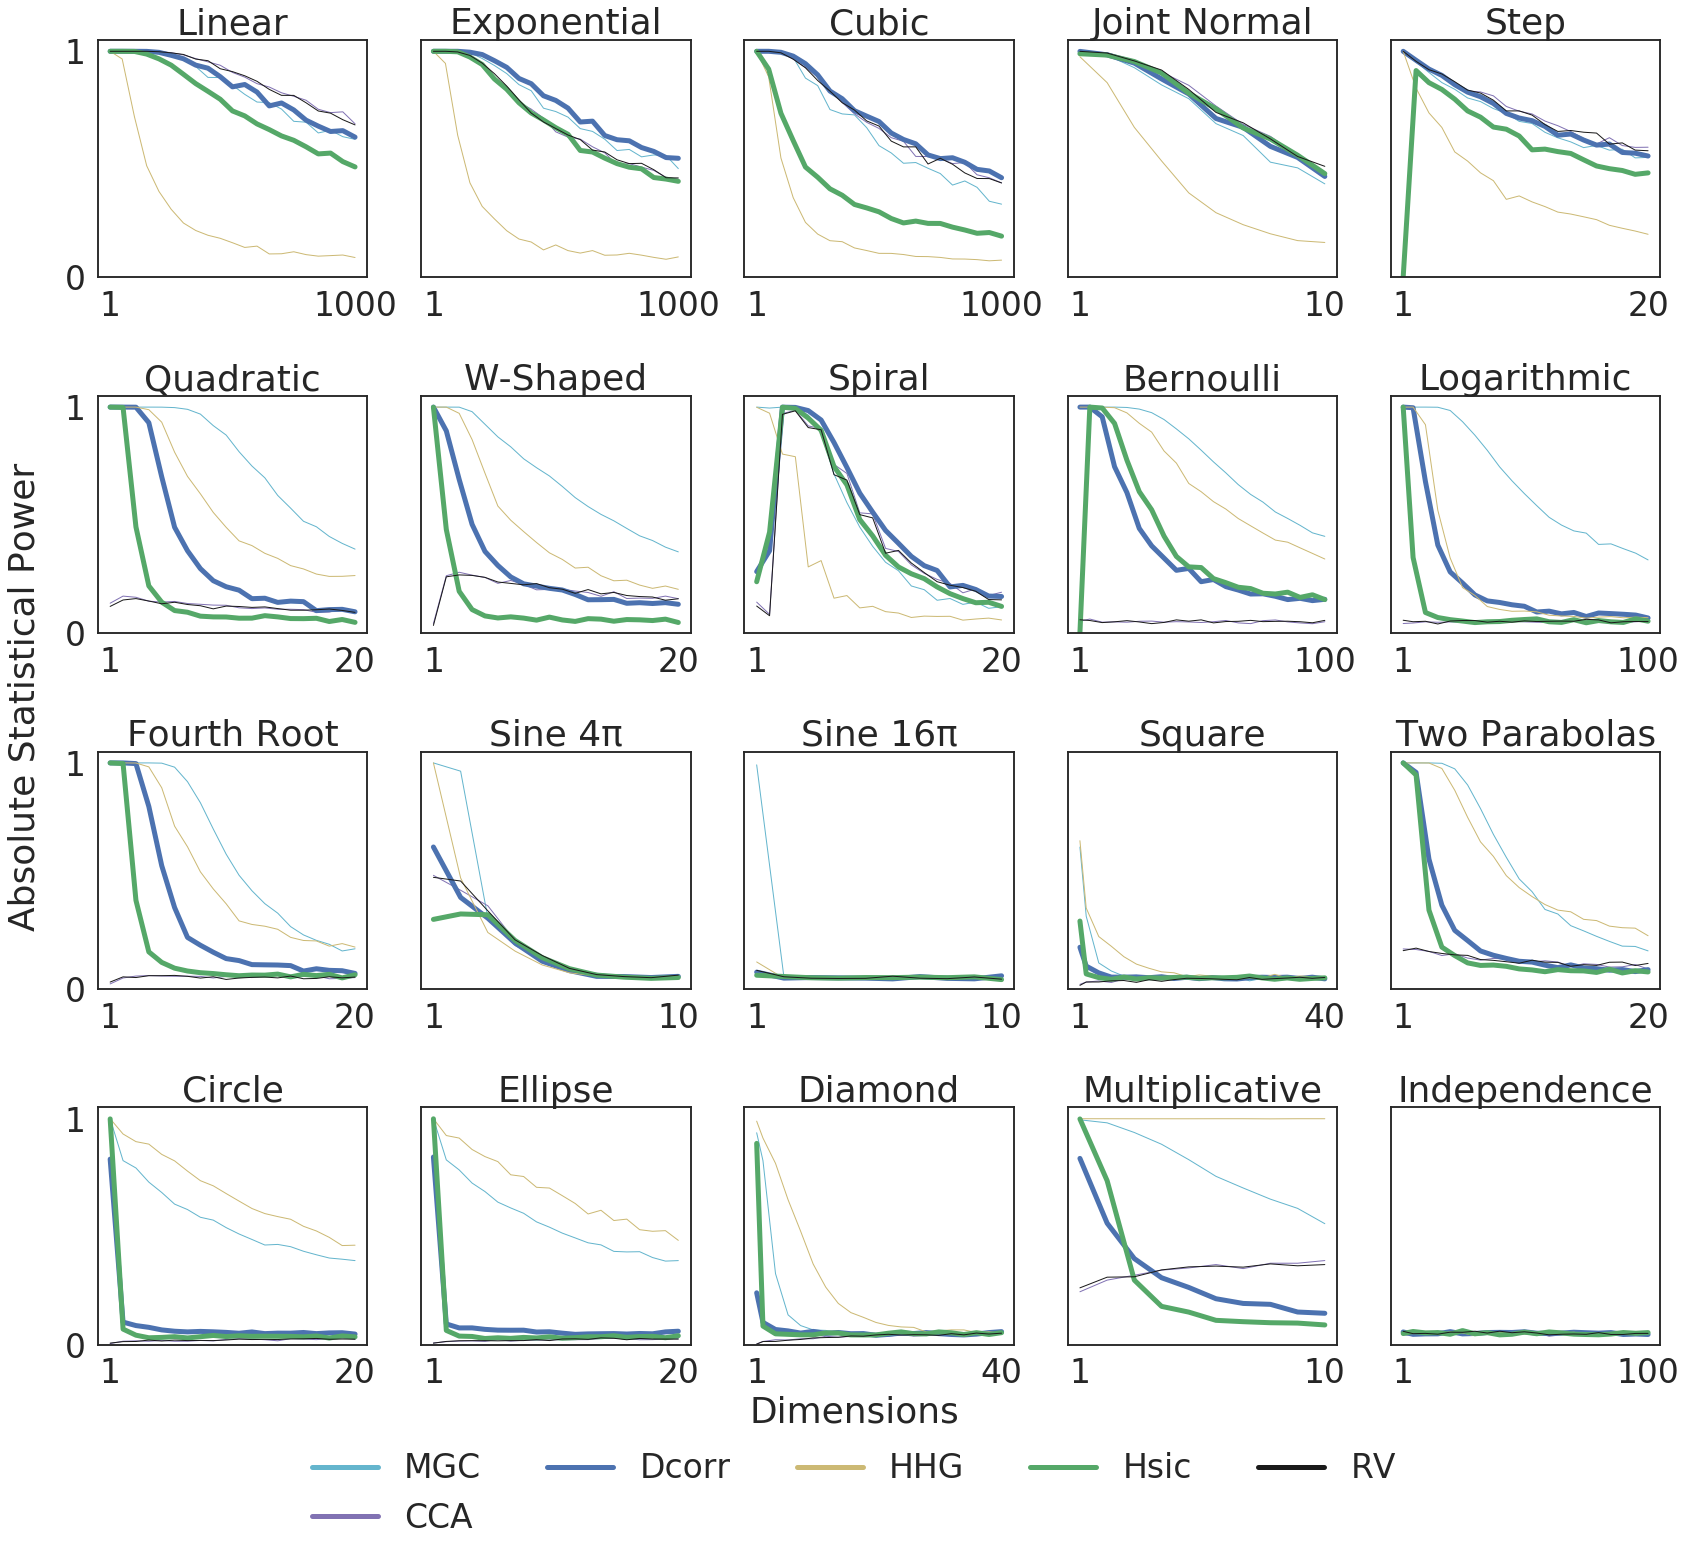

In [9]:
plot_power()